In [1]:
# Import necessary libraries
import os
import sys
import joblib
import numpy as np
import pandas as pd
from joblib import dump
import subprocess as sp
import dask.array as da
from pprint import pprint
import matplotlib.pyplot as plt
from odc.io.cgroups import get_cpu_quota
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
training_data = "S_training_data(1).txt"

# Define all candidate classifiers
models = {
    "RandomForest": RandomForestClassifier,
    "GradientBoosting": GradientBoostingClassifier
}

# Define the metric
metric = 'balanced_accuracy'

In [3]:
# Set cross-validation splits
inner_cv_splits = 5
outer_cv_splits = 5
test_size = 0.20

In [4]:
# Get the number of CPUs available
ncpus = round(get_cpu_quota())
print('ncpus = ' + str(ncpus))

ncpus = 4


In [5]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

#convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

In [6]:
# Parameter grid for GridSearchCV
param_grids = {
    "RandomForest": {
        'class_weight': ['balanced'],
        'n_estimators': [250],
        'criterion': ['gini', 'entropy'],
        'max_depth': [10],
        'max_features': ['sqrt', 'log2']
    },
    "GradientBoosting": {
        'n_estimators': [100, 250],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}


In [7]:
# Define the outer cross-validation
outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True, random_state=0)

# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []

results_summary = {}

for model_name, Classifier in models.items():
    print(f"\n===== Evaluating {model_name} =====")
    param_grid = param_grids[model_name]
    
    acc, f1, roc_auc = [], [], []
    i = 1
    
    for train_index, test_index in outer_cv.split(X, y):
        print(f"Working on {i}/{outer_cv_splits} outer cv split", end='\r')
        model = Classifier()
        
        X_tr, X_tt = X[train_index, :], X[test_index, :]
        y_tr, y_tt = y[train_index], y[test_index]
        
        inner_cv = KFold(n_splits=inner_cv_splits, shuffle=True, random_state=0)
        
        clf = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=metric,
            n_jobs=ncpus,
            refit=True,
            cv=inner_cv,
        )
        clf.fit(X_tr, y_tr)
        
        best_model = clf.best_estimator_
        pred = best_model.predict(X_tt)
        probs = getattr(best_model, "predict_proba", lambda x: np.zeros((len(x), len(np.unique(y)))))(X_tt)
        
        y_tt_bin = label_binarize(y_tt, classes=np.unique(y))
        for j in range(y_tt_bin.shape[1]):
            fpr, tpr, _ = roc_curve(y_tt_bin[:, j], probs[:, j]) if probs.ndim > 1 else ([], [], [])
            if len(fpr) > 0:
                roc_auc.append(auc(fpr, tpr))
        
        acc.append(balanced_accuracy_score(y_tt, pred))
        f1.append(f1_score(y_tt, pred, average='weighted'))
        i += 1

    results_summary[model_name] = {
        "roc_auc_mean": np.mean(roc_auc),
        "acc_mean": np.mean(acc),
        "f1_mean": np.mean(f1)
    }

    print(f"\n{model_name} — Mean ROC AUC: {np.mean(roc_auc):.4f}")
    print(f"{model_name} — Mean Accuracy: {np.mean(acc):.4f}")
    print(f"{model_name} — Mean F1 Score: {np.mean(f1):.4f}")

    # Final training on full dataset
    rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=0)
    clf = GridSearchCV(Classifier(), param_grid, scoring=metric, verbose=1, cv=rs.split(X, y), n_jobs=ncpus)
    clf.fit(X, y)
    
    best_params = clf.best_params_
    new_model = Classifier(**best_params)
    new_model.fit(X, y)
    
    model_filename = f"S_model_{model_name.lower()}.joblib"
    dump(new_model, model_filename)
    print(f"Saved best {model_name} model to {model_filename}")



===== Evaluating RandomForest =====
Working on 5/5 outer cv split
RandomForest — Mean ROC AUC: 0.9657
RandomForest — Mean Accuracy: 0.8325
RandomForest — Mean F1 Score: 0.8329
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Saved best RandomForest model to S_model_randomforest.joblib

===== Evaluating GradientBoosting =====
Working on 5/5 outer cv split
GradientBoosting — Mean ROC AUC: 0.9641
GradientBoosting — Mean Accuracy: 0.8270
GradientBoosting — Mean F1 Score: 0.8277
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Saved best GradientBoosting model to S_model_gradientboosting.joblib


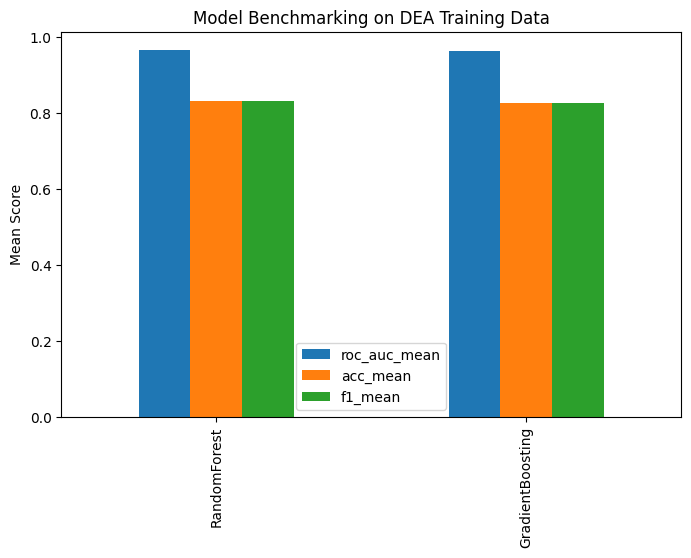

In [8]:
# Summarize and compare results
df_results = pd.DataFrame(results_summary).T
df_results.plot(kind='bar', figsize=(8,5))
plt.title("Model Benchmarking on DEA Training Data")
plt.ylabel("Mean Score")
plt.show()